------------------
# Name : Abdelrahman Basha
------------------

## Importing required libraries

In [1]:
#importing libraries

import os
import numpy as np
import pandas as pd
from time import time
from skimage import io
import seaborn as sns
from skimage import exposure
import matplotlib.pyplot as plt
from itertools import combinations
from skimage.transform import resize
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report,accuracy_score


## Reading the Folders 

In [2]:
os.listdir(path='.')

def getListOfFiles(dirName):
    
    listOfFile = os.listdir(dirName)
    allFiles = list()
    
    for i in listOfFile:
        fullPath = os.path.join(dirName, i)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles        


dirName1 ='texture/training'
dirName2 ='texture/testing'

listOfFiles1 = getListOfFiles(dirName1)

listOfFiles1 = list()
for (dirpath, dirnames, filenames) in os.walk(dirName1):
    listOfFiles1 += [os.path.join(dirpath, file) for file in filenames]

    
listOfFiles2 = getListOfFiles(dirName2)

listOfFiles2 = list()
for (dirpath, dirnames, filenames) in os.walk(dirName2):
    listOfFiles2 += [os.path.join(dirpath, file) for file in filenames]
    

#     for i in listOfFiles1:
#         print(i)    

## Reading the images for preproccesing

In [3]:
#Pairs for training folder
pairs1 = list(combinations(listOfFiles1, 2))

#pairs for testing folder
pairs2 = list(combinations(listOfFiles2, 2))

In [4]:
#print(pairs1)

In [5]:
pictures_for_training_mlp = {}
pictures_for_training_mlp_Fengineering = {}

for i in listOfFiles1:
    # for MLP model
    pictures_for_training_mlp[i]= resize(io.imread(i), (32,32))
    
    pictures_for_training_mlp[i]=pictures_for_training_mlp[i].reshape(32*32) 
    
    # for feature engineering later
    pictures_for_training_mlp_Fengineering[i]= resize(io.imread(i), (4,4)) 
    
    pictures_for_training_mlp_Fengineering[i]=exposure.equalize_hist(pictures_for_training_mlp_Fengineering[i].reshape(4*4))

    
    
imgs_flattened_mlp = [[pictures_for_training_mlp[file1], pictures_for_training_mlp[file2]] for file1, file2 in pairs1]

imgs_flattened_mlp_Fengineering = [[pictures_for_training_mlp_Fengineering[file1], pictures_for_training_mlp_Fengineering[file2]] for file1, file2 in pairs1]

imgs_flattened_mlp = np.array(imgs_flattened_mlp)

imgs_flattened_mlp_Fengineering = np.array(imgs_flattened_mlp_Fengineering)



#imgs = imgs.reshape(imgs.shape[0] ,-1) 
imgs_flattened_mlp = imgs_flattened_mlp.reshape(imgs_flattened_mlp.shape[0] ,2*32*32) 

imgs_flattened_mlp_Fengineering = imgs_flattened_mlp_Fengineering.reshape(imgs_flattened_mlp_Fengineering.shape[0] ,2*4*4) 

In [6]:
print('Shape of Feature engineered images to check for the 32 features :',imgs_flattened_mlp_Fengineering.shape)

Shape of Feature engineered images to check for the 32 features : (16110, 32)


In [7]:
# for image matching function

pictures_for_training_imgMat = {}
pictures_for_training_imgMat_FE = {}

for i in listOfFiles1:
    pictures_for_training_imgMat[i]= resize(io.imread(i), (32,32))
    
    pictures_for_training_imgMat_FE[i]= resize(io.imread(i), (4,4))
    pictures_for_training_imgMat_FE[i]=exposure.equalize_hist(pictures_for_training_imgMat_FE[i])
    
imgs_notflattened=[[pictures_for_training_imgMat[file1], pictures_for_training_imgMat[file2]] for file1, file2 in pairs1]

imgs_notflattened_FE=[[pictures_for_training_imgMat_FE[file1], pictures_for_training_imgMat_FE[file2]] for file1, file2 in pairs1]

imgs_notflattened = np.array(imgs_notflattened)

imgs_notflattened_FE = np.array(imgs_notflattened_FE)


In [8]:
#Preparing label 

y_label = []

for imga,imgb in pairs1:
    if os.path.dirname(imga) == os.path.dirname(imgb):
        y_label.append(1)
    else:
        y_label.append(0)
        

## Defining a function for subsampling the dataset

### as it gave me bad recall 0 for class and 100% for the other in my first try .

In [9]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

# 1.3 Image matching

In [10]:
imgs_notflattened,y_label_match=balanced_subsample(imgs_notflattened,y_label)

In [11]:
#splitting data for Image matching simple classifer

X1_train, X1_valid, y1_train, y1_valid = train_test_split(imgs_notflattened,y_label_match, train_size=0.7, random_state=42, stratify=y_label_match)

### Defining the functions

In [12]:
def MatchingImages(imgA,imgB,method='cc',normalize='false'):
    
    if normalize == 'true':
        imgA = (imgA - np.mean(imgA))/np.std(imgA)
        
    if (method == 'cc'):
        cc = 0       
        for x in range ( len( imgA )   ):
            for y in range ( len ( imgA[x] ) ):              
                cc += imgA[x][y]*imgB[x][y]         
        return cc 
    
    
    elif (method == 'conv'):
        conv_imageA =  np.flip(  np.flip( imgA , axis = 0 ) , axis = 1   )                    
        conv = 0 ;       
        for x in range ( len( conv_imageA )   ):
            for y in range ( len ( conv_imageA[x] ) ):              
                conv += conv_imageA[x][y]*imgB[x][y]         
        return conv  
    
    
    
    elif (method == 'ssd'):
        ssd = 0 ;       
        for x in range ( len( imgA )   ):
            for y in range ( len ( imgA[x] ) ):              
                ssd  += np.square( imgA[x][y] - imgB[x][y] )          
        return ssd

#### or using this function

In [13]:
# def MatchingImages(imgA,imgB,method='cc',normalize='false'):
    
#     if normalize == 'true':
#         imgA = (imgA - np.mean(imgA))/np.std(imgA)
        
#     if (method == 'cc'):
#         return np.sum(imgA * imgB)
    
#     elif (method == 'conv'):
#         return np.sum(np.flip(np.flip(imgA, axis=0), axis=1) * imgB)
    
#     elif (method == 'ssd'):
#         return np.sum(np.power((imgA - imgB), 2))

In [14]:
scores_cc_normalized_valid=[]
scores_cc_normalized_train=[]

for i1,i2 in X1_valid:
    scores_cc_normalized_valid.append(MatchingImages(i1,i2,'cc','true'))
    
for i1,i2 in X1_train:
    scores_cc_normalized_train.append(MatchingImages(i1,i2,'cc','true'))
    

print('Threshold of training :',np.median(scores_cc_normalized_train) )


Threshold of training : 0.6449919721205272


In [15]:
scores_cc_non_valid=[]
scores_cc_non_train=[]

for i1,i2 in X1_valid:
    scores_cc_non_valid.append( MatchingImages(i1,i2) )   

for i1,i2 in X1_train:
    scores_cc_non_train.append( MatchingImages(i1,i2) )   



print('Threshold of training :',np.median(scores_cc_non_train) )

Threshold of training : 250.00811803152666


In [16]:
scores_conv_normalized_valid=[]
scores_conv_normalized_train=[]

for i1,i2 in X1_valid:
    scores_conv_normalized_valid.append(MatchingImages(i1,i2,'conv','true'))

for i1,i2 in X1_train:
    scores_conv_normalized_train.append( MatchingImages(i1,i2,'conv','true') )
    
    
print('Threshold of training :',np.median(scores_conv_normalized_train) )

Threshold of training : -0.34840621766586277


In [17]:
scores_conv_non_valid=[]
scores_conv_non_train=[]

for i1,i2 in X1_valid:
    scores_conv_non_valid.append(MatchingImages(i1,i2,method='conv'))

for i1,i2 in X1_train:
    scores_conv_non_train.append(MatchingImages(i1,i2,method='conv'))
    
print('Threshold of training :',np.median(scores_conv_non_train) )


Threshold of training : 249.96324586697418


In [18]:
scores_ssd_normalized_valid=[]
scores_ssd_normalized_train=[]

for i1,i2 in X1_valid:
    scores_ssd_normalized_valid.append(MatchingImages(i1,i2,'ssd','true'))

for i1,i2 in X1_train:
    scores_ssd_normalized_train.append(MatchingImages(i1,i2,'ssd','true'))
    
print('Threshold of training :',np.median( scores_ssd_normalized_train) )


Threshold of training : 1275.913388931837


In [19]:
scores_ssd_non_valid=[]
scores_ssd_non_train=[]

for i1,i2 in X1_valid:
    scores_ssd_non_valid.append(MatchingImages(i1,i2,method='ssd') )

for i1,i2 in X1_train:
    scores_ssd_non_train.append(MatchingImages(i1,i2,method='ssd') )
                          
print('Threshold of training :',np.median(scores_ssd_non_train) )


Threshold of training : 7.573379469434844


## Here i used the threshold using the median of cross-correlation with normalization scores as it gave the best accuracy, recall and precision compared to others

In [20]:
y_pred=[]
#< >
threshold_training=np.median(scores_cc_normalized_train)

for x in range( len( X1_valid ) ):

    if scores_cc_normalized_valid[x] > threshold_training:
        y_pred.append(1)
    else:
        y_pred.append(0)     


Classification Report  : 

              precision    recall  f1-score   support

         0.0       0.56      0.59      0.57       784
         1.0       0.57      0.54      0.55       783

    accuracy                           0.56      1567
   macro avg       0.56      0.56      0.56      1567
weighted avg       0.56      0.56      0.56      1567



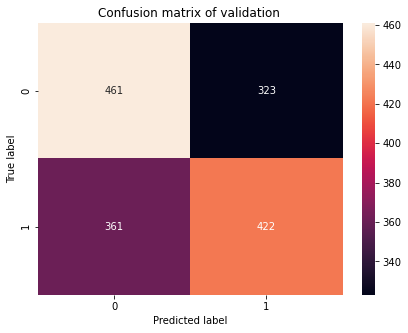

In [21]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of validation '
sns.heatmap(confusion_matrix(y1_valid, y_pred), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(f"\nClassification Report  : \n\n{classification_report(y1_valid,y_pred)}")

# 1.4 MLP Model 

In [22]:
imgs_flattened_mlp,y_label_mlp=balanced_subsample(imgs_flattened_mlp,y_label)

In [23]:
#splitting data for mlp
X_train, X_valid, y_train, y_valid = train_test_split(imgs_flattened_mlp,y_label_mlp, train_size=0.7, random_state=42, stratify=y_label_mlp)

In [24]:
mlp_train = MLPClassifier(max_iter=15,solver='sgd',verbose='true',random_state=1,hidden_layer_sizes=(40,))

mlp_train.fit(X_train, y_train)

y_mlp_of_Valid=mlp_train.predict(X_valid)


Iteration 1, loss = 0.69438874
Iteration 2, loss = 0.69346404
Iteration 3, loss = 0.69303326
Iteration 4, loss = 0.69295202
Iteration 5, loss = 0.69156863
Iteration 6, loss = 0.69062210
Iteration 7, loss = 0.68953073
Iteration 8, loss = 0.69092643
Iteration 9, loss = 0.68919276
Iteration 10, loss = 0.69017483
Iteration 11, loss = 0.68852433
Iteration 12, loss = 0.68775798
Iteration 13, loss = 0.68729414
Iteration 14, loss = 0.68649227
Iteration 15, loss = 0.68676909


C:\Users\zeroo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.54      0.78      0.64       784
         1.0       0.60      0.33      0.43       783

    accuracy                           0.56      1567
   macro avg       0.57      0.56      0.53      1567
weighted avg       0.57      0.56      0.53      1567



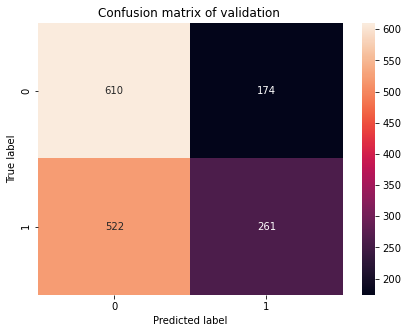

In [25]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of validation '
sns.heatmap(confusion_matrix( y_valid, y_mlp_of_Valid ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(classification_report(y_valid,y_mlp_of_Valid))

## 1.5 Classification comparison


### MLP case

In [26]:
pictures_for_test = {}
pictures_for_test_FE = {}

for i in listOfFiles2:
    pictures_for_test[i]= resize(io.imread(i), (32,32))
    pictures_for_test[i]=pictures_for_test[i].reshape(32*32)
    
    pictures_for_test_FE[i]= resize(io.imread(i), (4,4))
    pictures_for_test_FE[i]=exposure.equalize_hist(pictures_for_test_FE[i].reshape(4*4))
    
imgs2_test = [[ pictures_for_test[ file1 ], pictures_for_test[ file2 ]] for file1, file2 in pairs2]

imgs2_test_FE = [[ pictures_for_test_FE[ file1 ], pictures_for_test_FE[ file2 ]] for file1, file2 in pairs2]

imgs2_test = np.array(imgs2_test)
imgs2_test_FE = np.array(imgs2_test_FE)

#imgs = imgs.reshape(imgs.shape[0] ,-1) 
X_test_Flattened = imgs2_test.reshape(imgs2_test.shape[0] ,2*32*32) 

X_test_Flattened_FE = imgs2_test_FE.reshape(imgs2_test_FE.shape[0] ,2*4*4) 

In [27]:
#Preparing label 

y_test = []

for imga,imgb in pairs2:
    if os.path.dirname(imga) == os.path.dirname(imgb):
        y_test.append(1)
    else:
        y_test.append(0)

In [28]:
# prediction for X_test
start1 = time()
y_mlp2=mlp_train.predict(X_test_Flattened)
print(f'Time taken to predict: {time() - start1} seconds')

Time taken to predict: 0.04412531852722168 seconds


              precision    recall  f1-score   support

         0.0       0.54      0.77      0.63      1826
         1.0       0.59      0.34      0.43      1827

    accuracy                           0.55      3653
   macro avg       0.56      0.55      0.53      3653
weighted avg       0.56      0.55      0.53      3653



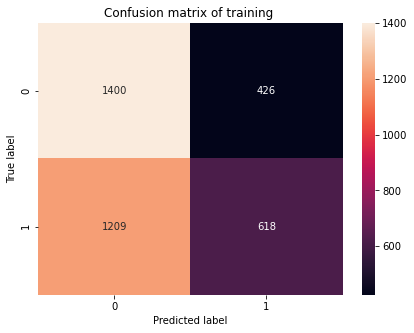

In [29]:
y_mlp_of_train=mlp_train.predict(X_train)

plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of training '
sns.heatmap(confusion_matrix( y_train, y_mlp_of_train ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(classification_report(y_train,y_mlp_of_train))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1500
           1       0.14      0.33      0.20       270

    accuracy                           0.60      1770
   macro avg       0.49      0.49      0.47      1770
weighted avg       0.74      0.60      0.65      1770



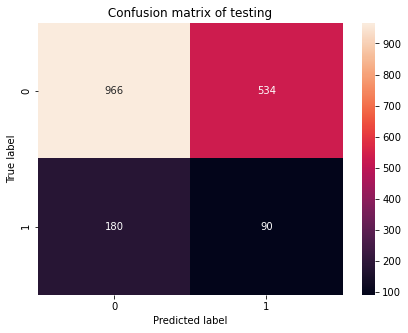

In [30]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = ' Confusion matrix of testing '
sns.heatmap(confusion_matrix( y_test, y_mlp2 ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');


print(classification_report(y_test,y_mlp2))

### Image matching threshold case

In [31]:
# for imagematching function for testing folder

pictures_for_test_imgM={}
pictures_for_testing_imgMat_FE={}

for i in listOfFiles2:
    pictures_for_test_imgM[i]= resize(io.imread(i), (32,32))
    
    pictures_for_testing_imgMat_FE[i]= resize(io.imread(i), (4,4))
    pictures_for_testing_imgMat_FE[i]=exposure.equalize_hist(pictures_for_testing_imgMat_FE[i])

imgs_notflattened2_M=[[pictures_for_test_imgM[file1], pictures_for_test_imgM[file2]] for file1, file2 in pairs2]

imgs_notflattened2_FE=[[pictures_for_testing_imgMat_FE[file1], pictures_for_testing_imgMat_FE[file2]] for file1, file2 in pairs2]


X_test_notFlattened = np.array(imgs_notflattened2_M)

X_test_notFlattened_FE= np.array(imgs_notflattened2_FE)

In [32]:
scores_cc_normlized_test=[]
for i1,i2 in X_test_notFlattened:
    scores_cc_normlized_test.append(MatchingImages(i1,i2,'cc','true'))


Classification Report  : 

              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      1826
         1.0       0.57      0.57      0.57      1827

    accuracy                           0.57      3653
   macro avg       0.57      0.57      0.57      3653
weighted avg       0.57      0.57      0.57      3653



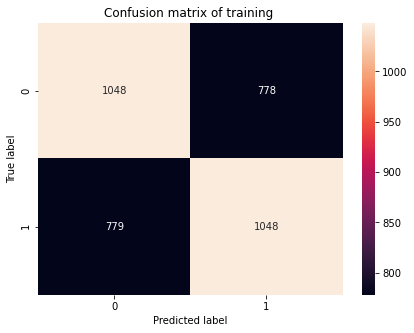

In [33]:
y_pred2_train=[]

for x in range( len( scores_cc_normalized_train ) ):

    if scores_cc_normalized_train[x] > threshold_training:
        y_pred2_train.append(1)
    else:
        y_pred2_train.append(0)
        
               
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of training '
sns.heatmap(confusion_matrix( y_train, y_pred2_train ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');
print(f"\nClassification Report  : \n\n{classification_report(y_train,y_pred2_train)}")

In [34]:
start2=time()

y_pred2_test=[]
for x in range( len( scores_cc_normlized_test ) ):

    if scores_cc_normlized_test[x] > threshold_training:
        y_pred2_test.append(1)
    else:
        y_pred2_test.append(0)     
        
print(f'Time taken to run: {time() - start2} seconds')

Time taken to run: 0.0 seconds



Classification Report  : 

              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1500
           1       0.21      0.57      0.30       270

    accuracy                           0.60      1770
   macro avg       0.55      0.59      0.51      1770
weighted avg       0.78      0.60      0.66      1770



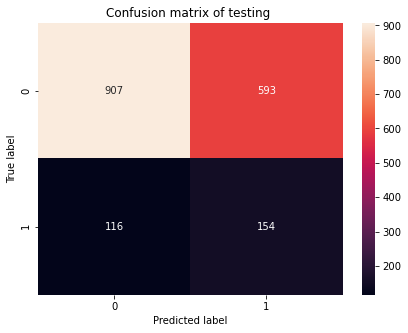

In [35]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of testing '
sns.heatmap(confusion_matrix( y_test, y_pred2_test ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');
print(f"\nClassification Report  : \n\n{classification_report(y_test,y_pred2_test)}")

### The performance of the simple classifer was better as shown above with classification reports

### The time taking to predict in threshold img matching case (0.008 secs) faster than MLP case (0.0239 secs), also the simple classifier was better as the recall was better than the mlp case in classification report ,also the accuracy was better.

### The generlization of both classifiers is bad as the accs were 58% and 60% on the test data.

### The Robustness is also bad as the model could not classify well , and maybe if we did the best case for feature engineering will make it performs well in addition to other factors .

### Furthermore, the training performance is so bad which means the model could not learn well.

-----------------------------------
# 1.6 Feature Engineering
------------------------------------

### FE for section 1.3

In [36]:
imgs_notflattened_FE,y_label_match_FE=balanced_subsample(imgs_notflattened_FE,y_label)

In [37]:
#splitting data for Image matching simple classifer

X1_train_FE, X1_valid_FE, y1_train_FE, y1_valid_FE = train_test_split(imgs_notflattened_FE,y_label_match_FE, train_size=0.7, random_state=42, stratify=y_label_match_FE)

In [38]:
scores_cc_normalized_valid_FE=[]
scores_cc_normalized_train_FE=[]

for i1,i2 in X1_valid_FE:
    scores_cc_normalized_valid_FE.append(MatchingImages(i1,i2,'cc','true'))
    
for i1,i2 in X1_train_FE:
    scores_cc_normalized_train_FE.append(MatchingImages(i1,i2,'cc','true'))
    

print('Threshold of training :',np.median(scores_cc_normalized_train_FE) )


Threshold of training : 0.5303720292005577


In [39]:
y_pred_FE=[]
#< >
threshold_training_FE=np.median(scores_cc_normalized_train_FE)

for x in range( len( X1_valid_FE ) ):

    if scores_cc_normalized_valid_FE[x] > threshold_training_FE:
        y_pred_FE.append(1)
    else:
        y_pred_FE.append(0)     


Classification Report  : 

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60       784
         1.0       0.60      0.60      0.60       783

    accuracy                           0.60      1567
   macro avg       0.60      0.60      0.60      1567
weighted avg       0.60      0.60      0.60      1567



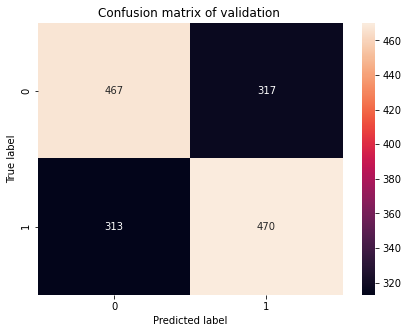

In [40]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of validation '
sns.heatmap(confusion_matrix(y1_valid_FE, y_pred_FE), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(f"\nClassification Report  : \n\n{classification_report(y1_valid_FE,y_pred_FE)}")

### The performance of model with feature engineering is better as the acc is 61% and before was 56% , also the recall and precision were better .

### FE for section1.4

In [41]:
imgs_flattened_mlp_Fengineering,y_label_FE=balanced_subsample(imgs_flattened_mlp_Fengineering,y_label)

In [42]:
#splitting data for Image matching simple classifer

X_train_FE, X_valid_FE, y_train_FE, y_valid_FE = train_test_split(imgs_flattened_mlp_Fengineering,y_label_FE, train_size=0.7, random_state=42, stratify=y_label_FE)

In [43]:
mlp_train_FE = MLPClassifier(max_iter=15,solver='sgd',verbose='true',random_state=1,hidden_layer_sizes=(40,))

mlp_train_FE.fit(X_train_FE, y_train_FE)

y_mlp_validFE=mlp_train_FE.predict(X_valid_FE)


Iteration 1, loss = 0.71486182
Iteration 2, loss = 0.69733144
Iteration 3, loss = 0.68993279
Iteration 4, loss = 0.68850889
Iteration 5, loss = 0.68761747
Iteration 6, loss = 0.68694996
Iteration 7, loss = 0.68637718
Iteration 8, loss = 0.68583543
Iteration 9, loss = 0.68529081
Iteration 10, loss = 0.68476282
Iteration 11, loss = 0.68427404
Iteration 12, loss = 0.68385637
Iteration 13, loss = 0.68325935
Iteration 14, loss = 0.68281270
Iteration 15, loss = 0.68232336


C:\Users\zeroo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



Classification Report  : 

              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54       784
         1.0       0.56      0.63      0.59       783

    accuracy                           0.57      1567
   macro avg       0.57      0.57      0.56      1567
weighted avg       0.57      0.57      0.56      1567



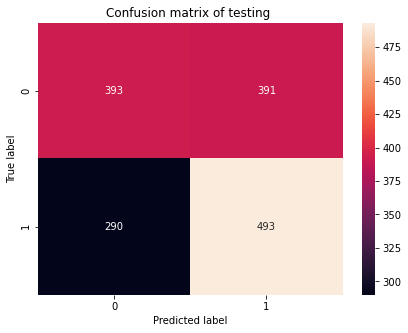

In [44]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of testing '
sns.heatmap(confusion_matrix( y_valid_FE, y_mlp_validFE ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(f"\nClassification Report  : \n\n{classification_report(y_valid_FE,y_mlp_validFE)}")

### The performance of model with feature engineering is better as the acc is 56% and before was 54% , also the recall and precision were better

---------------------
# 1.7 Discussion on Feature Engineering
--------------------

## I used Histogram Equalization as an image processing technique as it improves contrast in images. It's is a method to process images in order to adjust the contrast of an image by modifying the intensity distribution of the histogram. The objective of this technique is to give a linear trend to the cumulative probability function associated to the image.

## The processing of histogram equalization relies on the use of the cumulative probability function (cdf). The cdf is a cumulative sum of all the probabilities lying in its domain.

### section 1.3 simple classifier test

In [45]:

scores_cc_normlized_test_FE=[]
for i1,i2 in X_test_notFlattened_FE:
    scores_cc_normlized_test_FE.append(MatchingImages(i1,i2,'cc','true'))

In [46]:
y_pred2_test_FE=[]

for x in range( len( scores_cc_normlized_test_FE ) ):

    if scores_cc_normlized_test_FE[x] > threshold_training_FE:
        y_pred2_test_FE.append(1)
    else:
        y_pred2_test_FE.append(0)


Classification Report  : 

              precision    recall  f1-score   support

           0       0.89      0.64      0.74      1500
           1       0.21      0.54      0.31       270

    accuracy                           0.63      1770
   macro avg       0.55      0.59      0.52      1770
weighted avg       0.78      0.63      0.68      1770



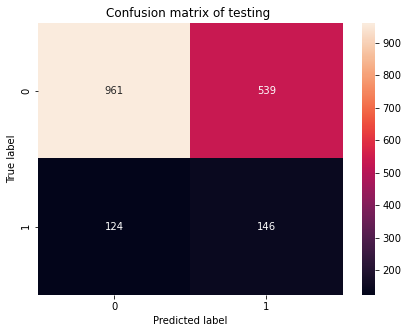

In [47]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of testing '
sns.heatmap(confusion_matrix( y_test, y_pred2_test_FE ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');
print(f"\nClassification Report  : \n\n{classification_report(y_test,y_pred2_test_FE)}")

### The model performance is better as the acc: 63% and before feature engineering was 60%, also the recall and precision are better

###  section 1.4 MLP test

In [48]:
y_mlp_testFE=mlp_train_FE.predict(X_test_Flattened_FE)


Classification Report  : 

              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1500
           1       0.20      0.48      0.29       270

    accuracy                           0.63      1770
   macro avg       0.54      0.57      0.52      1770
weighted avg       0.77      0.63      0.68      1770



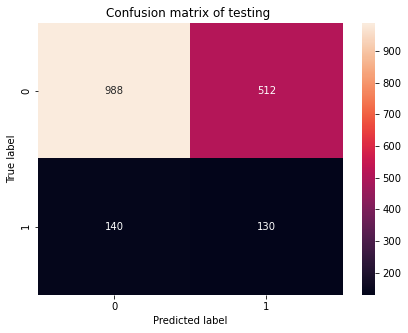

In [49]:
plt.figure(figsize=[15, 5])
plt.subplot(1,2,1)
title = 'Confusion matrix of testing '
sns.heatmap(confusion_matrix( y_test, y_mlp_testFE ), annot=True, fmt='')
plt.title(title)
plt.xlabel('Predicted label');
plt.ylabel('True label');

print(f"\nClassification Report  : \n\n{classification_report(y_test,y_mlp_testFE)}")

### The model performance is better as the acc: 63% and before feature engineering was 58%, also the recall and precision